In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import interpolate 
from torch.autograd import Variable
import imp
import torchaudio
import torchvision as tv
import matplotlib.pyplot as plt
from IPython.display import Audio
import os, random
import pandas as pd
import mir_utils as miru
from torch.utils.data import Dataset, DataLoader
import librosa
import pytorch_utils
import pytorch_models
#reload these libraries because I change them often-ish
imp.reload(pytorch_utils)
imp.reload(miru)
imp.reload(pytorch_models)
from scipy.signal import resample
from sklearn import preprocessing
le_major = preprocessing.LabelEncoder()

SR = 22050//2
#functions
spec = torchaudio.functional.spectrogram

def getMeanLength(x):
    gl=x.apply(lambda z: len(z["audio"]),axis=1)
    print(gl.mean()/SR,gl.mean(),x["label"].iloc[0])

audio_df = pd.read_csv("../csvs/audio_df.csv")
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


/home/asalimi/miniconda3/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '
/home/asalimi/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/asalimi/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/least_an

In [3]:
audio_df = audio_df[audio_df["maj"]=="drums"]
audio_df["min"] = audio_df["min"].str.replace("tom_high","kick")
audio_df["min"] = audio_df["min"].str.replace("tom","kick")
audio_df["min"] = audio_df["min"].str.replace("rim","snare")
audio_df["min"] = audio_df["min"].str.replace("clap","snare")


In [4]:
le_major.fit(audio_df["min"])
le_major.classes_,le_major.inverse_transform([0,1,0,0])


(array(['hat', 'kick', 'shake', 'snare'], dtype=object),
 array(['hat', 'kick', 'hat', 'hat'], dtype=object))

In [5]:
# define weights
w = [len(audio_df)/np.sum(audio_df["min"]==x) for x in le_major.classes_]
w = torch.tensor(w).to(device)
w

tensor([ 3.3862,  3.3441, 48.9174,  2.5961], device='cuda:1',
       dtype=torch.float64)

In [6]:
%%time
#define a dataset
class audioDataset(torch.utils.data.Dataset):
    def __init__(self,audio_df,RSR=SR,transform=None):
        self.audio_df = audio_df
        self.minLength = SR
    def __len__(self):
        return len(self.audio_df)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        row = self.audio_df.iloc[idx]
        try:
            signal,sr = librosa.load(row["path"])
        except:
            signal = np.zeros(self.minLength)
            sr = self.minLength
        # resample to global SR
        signal = librosa.resample(signal,sr,self.minLength)
        # pad the audio length if too short
        nz = np.max((self.minLength-signal.shape[0],0))
        signal = np.concatenate([signal[0:self.minLength],np.zeros(nz)])
        sound={"signal":signal,"major":row["maj"],"minor":row["min"],"path":row["path"],"sr":SR}
        return sound
    
data_train = audioDataset(audio_df,SR)
train_loader = DataLoader(data_train, batch_size=32,shuffle=True, num_workers=0)
d = next(iter(train_loader))
# d

CPU times: user 1.21 s, sys: 4.33 ms, total: 1.21 s
Wall time: 1.21 s


torch.Size([32, 11025])
torch.Size([5512])


/home/asalimi/miniconda3/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/asalimi/miniconda3/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


kick
torch.Size([1, 30, 9])
5512


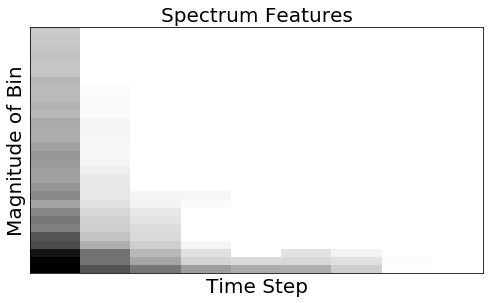

In [7]:
FREQ_BINS=30
TIME_STEPS=10
RESAMPLE_SR = 8000
#defining transformations

class specTrans(object):
    def __init__(self,num_mels=50,sr=SR,time_steps=20,amp_to_power=True):
        self.sr = sr
        self.amp_to_power=amp_to_power
        self.num_mels=num_mels
        self.ampP=torchaudio.transforms.AmplitudeToDB(stype='power',top_db=60)
        self.melP=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=sr,n_stft=None)
        self.hop_step=time_steps-1
    def __call__(self, sample):
        
        wf=sample
        wf=wf.reshape(-1,len(wf))
        sample_length=self.sr

        num_bins=wf[0].shape[0]
        win_length=self.sr//17
        hop_step=self.sr//self.hop_step
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window, num_bins, hop_step, win_length,2,normalized=True)
        s=self.melP(s)
        if self.amp_to_power:
            s=self.ampP(s)
        s = s - s.min()
        s = s/s.abs().max()

        freq=s
        freq[torch.isnan(freq)]=0
        freq=freq
        return freq.detach()
    
    

SCALE_FACTOR = 0.5
i = np.random.randint(len(d["signal"]))

original = d["signal"]
print(original.shape)
resampled_d = interpolate(d["signal"].reshape([len(d["signal"]),1,-1]),scale_factor = SCALE_FACTOR,recompute_scale_factor=False).reshape([len(d["signal"]),-1])
signal = resampled_d[i]
label = d["minor"][i]
fig = plt.figure(figsize=(20,4))
spec_tf = specTrans(FREQ_BINS,time_steps=TIME_STEPS,sr=SR,amp_to_power=True)
print(signal.shape)
transformed_sample = spec_tf(original[i].float())
ax = plt.subplot(1, 3, 1)
plt.tight_layout()

ft=transformed_sample[0]
sf=ft.detach().numpy()
plt.title("Spectrum Features",fontsize=20)
librosa.display.specshow(sf,cmap='gray_r',)
plt.xlabel("Time Step",fontsize=20)
plt.ylabel("Magnitude of Bin",fontsize=20)


print(label)
print(transformed_sample.shape)
print(len(signal))
Audio(signal[0:5000],rate=SR*0.5,autoplay=True)


torch.Size([1, 30, 9])

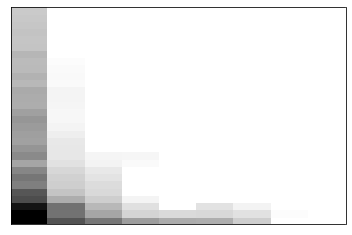

In [8]:
z =  torch.stack(list(map(spec_tf,d["signal"].float())),0)[i]
librosa.display.specshow(z[0].numpy(),cmap='gray_r',)
z.shape

In [9]:
      
spec_tf = specTrans(FREQ_BINS,time_steps=TIME_STEPS,amp_to_power=True)

adf = audio_df.copy()
train = adf.sample(frac=0.95,random_state=420) 
test_and_valid = adf.drop(train.index)
test = test_and_valid.sample(frac=0.90,random_state=420) 
# valid = test_and_valid.drop(test.index)

train_loader = DataLoader(audioDataset(train,SR), batch_size=128,shuffle=True, num_workers=0)
test_loader = DataLoader(audioDataset(test,SR), batch_size=256,shuffle=True, num_workers=0)

In [10]:
len(train),len(test)

(5623, 266)

In [11]:
class Conv_Spec_DVD(nn.Module):
    def __init__(self,embed_only=False,dropout=0.075):
        super(Conv_Spec_DVD, self).__init__()
        self.embed_only = embed_only
        self.dropout = dropout
        self.conv_1d = nn.Sequential(
                nn.Conv1d(1,128,500, stride=2, padding=5),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Conv1d(128, 128, 250, stride=2, padding=4),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Conv1d(128, 256, 100, stride=2, padding=3),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Conv1d(256, 256, 100, stride=2, padding=2),
                nn.MaxPool1d(kernel_size=3, stride=2, padding=1),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Conv1d(256, 128, 80, stride=1, padding=3),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Conv1d(128, 128, 40, stride=1, padding=3),
                nn.MaxPool1d(kernel_size=3, stride=2, padding=1),
                nn.BatchNorm1d(128),
                nn.ReLU())
        self.spectrogram_layer = nn.Sequential(
                nn.Linear(30*9,64),
                nn.ReLU(),
                nn.Dropout(self.dropout),
                nn.Linear(64,32),
                nn.Dropout(self.dropout),
                nn.Linear(32,16),
                nn.ReLU(),
                nn.Linear(16,16),
                nn.ReLU(),
                nn.Dropout(self.dropout),
                )
        self.l2 = nn.Sequential(
                nn.Linear(128,64),
                nn.ReLU(),
                nn.Dropout(self.dropout),
                nn.Linear(64,32),
                nn.Dropout(self.dropout),
                nn.Linear(32,16),
                nn.ReLU(),
                nn.Dropout(self.dropout),
                )
        self.l3 = nn.Sequential(
                  nn.Linear(16+16,32),
                  nn.ReLU(),
                  nn.Dropout(self.dropout),
                  nn.Linear(32,16),
                  nn.ReLU(),
                  nn.Linear(16,4),
                )

    def forward(self, x_sig,x_spec):
        x_sig = x_sig.float()
        bs = x_sig.shape[0]
        bs_spec = x_spec.shape[0]
        x_sig = x_sig.reshape(bs,1,-1).to(device)
        x1_1d = self.conv_1d(x_sig)
        flat_spec = x_spec.reshape([bs_spec,-1])
        x1_fc = self.spectrogram_layer(flat_spec)
        x1_1d = x1_1d.reshape(bs,-1)
        x2 = self.l2(x1_1d)
        x_agg = torch.cat((x2,x1_fc),dim=1)
        x_final = self.l3(x_agg)
        return x_final

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)
try:
    del cnet
except:
    pass
cnet = Conv_Spec_DVD(embed_only=False).to(device)

In [12]:
checkpoint = torch.load("models/1d_conv_dvd/0.542_0.1510_.checkpoint")

In [14]:
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(np.log(len(ecg_paths)/np.sum(ecg_paths).to_numpy()))).to(device)
loss_func = nn.CrossEntropyLoss(weight = w.float() )
lr = 0.001 # learning rate
optimizer = torch.optim.Adam(cnet.parameters(), lr=lr)
smallest_loss,smallest_vloss = 1,1
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

In [15]:
SCALE_FACTOR = 0.5
num_windows = 5
window_shift = 300
smallest_loss,smallest_vloss = 1000,1000
step = 0
for epoch in range(40): 
    for i, data in enumerate(train_loader, 0):
        train_loss = 0
        bs = len(data["signal"]) # batch size
        signal = interpolate(data["signal"].reshape([bs,1,-1]),scale_factor = SCALE_FACTOR,recompute_scale_factor=False).reshape([bs,1,-1])
        spectrums = torch.stack(list(map(spec_tf,data["signal"].float())),0).to(device)
        optimizer.zero_grad()
        outputs = cnet(signal,spectrums)
        y = torch.tensor(le_major.transform(data["minor"])).to(device)
        loss = loss_func(outputs,y.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if i%5==0:
            with torch.no_grad():
                val_loss = 0
                for iv,datav in enumerate(test_loader, 0):
                    signalv = interpolate(datav["signal"].reshape([len(datav["signal"]),1,-1]),scale_factor = SCALE_FACTOR,recompute_scale_factor=False).reshape([len(datav["signal"]),-1])
                    spectrumsv = torch.stack(list(map(spec_tf,datav["signal"].float())),0).to(device)
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    voutputs = cnet(signalv,spectrumsv )
                    vy = torch.tensor(le_major.transform(datav["minor"])).to(device)
                    vloss = loss_func(voutputs,vy.long())
                    val_loss += vloss
            print('[%d, %d] val loss: %.5f, loss: %.5f'%(epoch + 1, i , val_loss,train_loss))
    #         writer.add_scalar('Loss/Training', train_loss,)
    #         writer.add_scalar('Loss/Validation', val_loss)
            if val_loss < smallest_vloss:        
                torch.save({
                'epoch': epoch,
                'vloss': vloss,
                'model_state_dict': cnet.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, "models/1d_conv_dvd/%.3f_%.4f_.checkpoint"%(val_loss,train_loss,))
                smallest_vloss = val_loss
                smallest_loss = train_loss 

[1, 0] val loss: 2.81350, loss: 1.37624
[1, 5] val loss: 2.81861, loss: 1.37173
[1, 10] val loss: 2.68911, loss: 1.35766
[1, 15] val loss: 2.69621, loss: 1.32126
[1, 20] val loss: 2.48660, loss: 1.29793
[1, 25] val loss: 2.75829, loss: 1.17364
[1, 30] val loss: 2.29730, loss: 1.17024
[2, 0] val loss: 1.90972, loss: 1.03793
[2, 5] val loss: 2.92596, loss: 1.11160
[2, 10] val loss: 2.18394, loss: 1.05956
[2, 15] val loss: 2.00158, loss: 0.95324
[2, 20] val loss: 1.97463, loss: 1.06879
[2, 25] val loss: 2.09656, loss: 0.82585
[2, 30] val loss: 2.07094, loss: 0.77507
[2, 35] val loss: 1.91943, loss: 0.92593
[2, 40] val loss: 1.99271, loss: 0.86414
[3, 0] val loss: 1.75030, loss: 0.61526
[3, 5] val loss: 1.96307, loss: 0.87493
[3, 10] val loss: 1.83830, loss: 0.75659
[3, 15] val loss: 1.70240, loss: 0.82629
[3, 20] val loss: 2.28679, loss: 0.72691
[3, 25] val loss: 1.34982, loss: 0.74381
[3, 30] val loss: 1.72242, loss: 0.77447
[3, 35] val loss: 1.75981, loss: 0.79708
[3, 40] val loss: 2.25